In [1]:
# Standard libraries
import os
import random

# Data processing and data frames
import pandas as pd
from sklearn.model_selection import train_test_split

# PyTorch and PyTorch tools
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Image processing and transformations
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms

# Transformers library
from transformers import (
    DistilBertTokenizer,
    DistilBertModel,
    ViTFeatureExtractor,
    ViTImageProcessor,
    ViTModel
)

# Additional tools
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Importing clipModel.py, use the following method to add paths in Colab
# This method allows importing from specific directories using URLs

import sys
sys.path.append('/content/drive/MyDrive/COLAB/PROJECTs/CLIP')

In [3]:
import clipModel
clip_model = clipModel.CLIPModel()
tokenizer = clipModel.tokenizer
transform = clipModel.transform

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Script for setting up environment, importing libraries, and downloading the Flickr30k dataset

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hsankesara/flickr-image-dataset
!unzip flickr-image-dataset.zip -d flickr30k

In [5]:
# Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
lr = 1e-4
num_epochs = 4
patience = 2
best_loss = float('inf')
stopping_counter = 0
model_path = '/content/drive/MyDrive/COLAB/Checkpoints/best_clip_model.pth'

In [6]:
print(os.listdir("flickr30k"))

['flickr30k_images']


In [7]:
print(os.listdir("flickr30k/flickr30k_images"))

['results.csv', 'flickr30k_images']


In [8]:
# Processing the Flickr30k dataset to create training and test sets from image-caption pairs.

df = pd.read_csv("flickr30k/flickr30k_images/results.csv", sep="|")
df.columns = df.columns.str.strip()

data = df[['image_name', 'comment']]
data = data.groupby('image_name').head(4).sample(n=80000, random_state=42)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Check the outputs
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))


Train set size: 64000
Test set size: 16000


In [9]:
# Create image_paths and captions lists for training and testing

img_dir = "flickr30k/flickr30k_images/flickr30k_images"

train_image_paths = [os.path.join(img_dir, img_name) for img_name in train_data['image_name']]
train_captions = train_data['comment'].tolist()

test_image_paths = [os.path.join(img_dir, img_name) for img_name in test_data['image_name']]
test_captions = test_data['comment'].tolist()


In [10]:
# Check the lengths of the lists
print(f"Train image paths: {len(train_image_paths)}, captions: {len(train_captions)}) ")
print(f"Test image paths: {len(test_image_paths)}, captions: {len(test_captions)}")

Train image paths: 64000, captions: 64000) 
Test image paths: 16000, captions: 16000


In [11]:
# Custom PyTorch dataset class for loading and processing image-caption pairs, applying transformations for ViT and tokenizing captions for model input.
class CLIPDataset(Dataset):
    def __init__(self, image_paths, captions, transform=transform, tokenizer=tokenizer):
        self.image_paths = image_paths
        self.captions = captions
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        image = Image.open(image_path).convert('RGB')

        # Image processing for ViT
        image = self.transform(images=image)['pixel_values'][0]
        tokens = self.tokenizer(caption, padding='max_length', truncation=True, max_length=64, return_tensors='pt')

        return image, tokens['input_ids'].squeeze(), tokens['attention_mask'].squeeze()

In [12]:
# Create dataset objects using the CLIPDataset class
train_dataset = CLIPDataset(image_paths=train_image_paths, captions=train_captions, transform=transform, tokenizer=tokenizer)
test_dataset = CLIPDataset(image_paths=test_image_paths, captions=test_captions, transform=transform, tokenizer=tokenizer)

# Load data using DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Check the structure and shape of training data
train_batch = next(iter(train_loader))
images, input_ids, attention_masks = train_batch
print(images.shape, input_ids.shape, attention_masks.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64, 64]) torch.Size([64, 64])


In [14]:
# The train function is responsible for training the model over a given dataset.
# It iterates through the training data, computes projections for images and text, calculates
# similarity scores, computes the loss, and updates the model weights using backpropagation.

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, input_ids, attention_mask in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()
        image_proj, text_proj = model(images, input_ids, attention_mask)

        # Compute similarities between image and text projections
        logits_per_image = torch.matmul(image_proj, text_proj.T)
        logits_per_text = logits_per_image.T

        # Create labels for each image-text pair
        labels = torch.arange(len(images)).to(device)
        loss_image = criterion(logits_per_image, labels)
        loss_text = criterion(logits_per_text, labels)

        # Calculate total loss
        loss = (loss_image + loss_text) / 2
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [15]:
# The evaluate function performs evaluation on a given test dataset without updating model weights.
# It calculates the loss over the test set to assess the model's performance after training.

@torch.no_grad()
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0

    for images, input_ids, attention_mask in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        image_proj, text_proj = model(images, input_ids, attention_mask)

        logits_per_image = torch.matmul(image_proj, text_proj.T)
        logits_per_text = logits_per_image.T

        labels = torch.arange(len(images)).to(device)
        loss_image = criterion(logits_per_image, labels)
        loss_text = criterion(logits_per_text, labels)

        loss = (loss_image + loss_text) / 2
        total_loss += loss.item()

    return total_loss / len(test_loader)



In [17]:
# Set up the model, optimizer, and loss function for training
clip_model = clip_model.to(device)
optimizer = optim.Adam(clip_model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

# Define a learning rate scheduler that reduces learning rate when a metric has stopped improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# Training
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Perform training and validation
    train_loss = train(clip_model, train_loader, optimizer, criterion, device)
    test_loss = evaluate(clip_model, test_loader, criterion, device)

    # Check current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Update the learning rate based on validation loss
    scheduler.step(test_loss)

    # Get the new learning rate
    new_lr = optimizer.param_groups[0]['lr']
    lr_changed_message = f" (LR changed to {new_lr:.6f})" if new_lr != current_lr else ""

    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}{lr_changed_message}")

    # ModelCheckpoint - Save the best model based on test loss
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(clip_model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch+1} with test loss: {test_loss:.4f}")
        stopping_counter = 0  # Reset early stopping counter
    else:
        stopping_counter += 1

    # EarlyStopping - Stop training if no improvement in validation loss
    if stopping_counter >= patience:
        print("Early stopping triggered.")
        break



Epoch 1/4


Evaluating: 100%|██████████| 250/250 [02:39<00:00,  1.57it/s]


Train Loss: 2.1338, Test Loss: 0.7717
Model saved at epoch 1 with test loss: 0.7717

Epoch 2/4


Evaluating: 100%|██████████| 250/250 [02:38<00:00,  1.58it/s]


Train Loss: 0.5457, Test Loss: 0.5825
Model saved at epoch 2 with test loss: 0.5825

Epoch 3/4


Evaluating: 100%|██████████| 250/250 [02:39<00:00,  1.56it/s]


Train Loss: 0.3075, Test Loss: 0.5452
Model saved at epoch 3 with test loss: 0.5452

Epoch 4/4


Evaluating: 100%|██████████| 250/250 [02:38<00:00,  1.58it/s]

Train Loss: 0.2398, Test Loss: 0.5488


In [18]:
# The projection_function extracts and projects image embeddings from the test dataset.
# It processes each image through the image encoder and projection head, ensuring unique embeddings for each image.

@torch.no_grad()
def projection_function(model, test_loader, device):
    model.eval()
    unique_embeddings = {}

    for images, image_names, _ in tqdm(test_loader, desc="Projecting Test Images"):
        images = images.to(device)

        for img, img_name in zip(images, image_names):
            if img_name not in unique_embeddings:
                image_proj = model.image_encoder(img.unsqueeze(0))
                image_proj = model.projection(image_proj)
                unique_embeddings[img_name] = image_proj.squeeze(0)

    image_embeddings = torch.stack(list(unique_embeddings.values())).to(device)
    return image_embeddings

image_embeddings = projection_function(clip_model, test_loader, device)

Projecting Test Images: 100%|██████████| 250/250 [03:50<00:00,  1.08it/s]


In [19]:
# The find_matches function retrieves the top-k image matches for a given query text.
# It encodes the input text, computes cosine similarity between the text embedding and precomputed image embeddings,
# and visualizes the top-k most similar images from the dataset.

def find_matches(query_text, model=clip_model, tokenizer=tokenizer, image_embeddings=image_embeddings, test_dataset=test_dataset, device=device, top_k=5):
    model.eval()

    with torch.no_grad():
        # Tokenize the text and extract the embedding
        text_inputs = tokenizer(query_text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        input_ids = text_inputs['input_ids'].to(device)
        attention_mask = text_inputs['attention_mask'].to(device)

        # Extract text embedding and project it
        query_text_embedding = model.text_encoder(input_ids, attention_mask)
        query_text_embedding = model.projection(query_text_embedding).squeeze()

    # Calculate similarities between the text embedding and image embeddings
    similarities = F.cosine_similarity(query_text_embedding.unsqueeze(0), image_embeddings)
    top_k_indices = torch.topk(similarities, top_k * 2).indices

    # Create a set to keep track of unique image paths
    unique_image_paths = set()
    unique_indices = []

    for idx in top_k_indices:
        image_path = test_dataset.image_paths[idx]
        if image_path not in unique_image_paths:
            unique_image_paths.add(image_path)
            unique_indices.append(idx)

        if len(unique_indices) >= top_k:
            break

    # Visualize the top-k matched images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(unique_indices):
        image_path = test_dataset.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        plt.subplot(1, top_k, i + 1)
        plt.imshow(image)
        plt.title(f"Match {i+1}")
        plt.axis('off')

    plt.suptitle(f"Top {top_k} matches for query: '{query_text}'")
    plt.show()


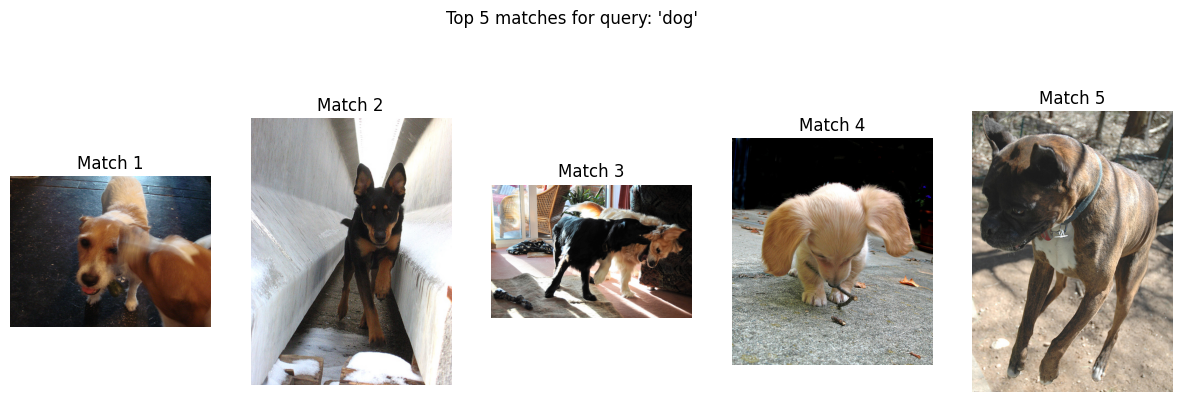

In [22]:
find_matches("dog")

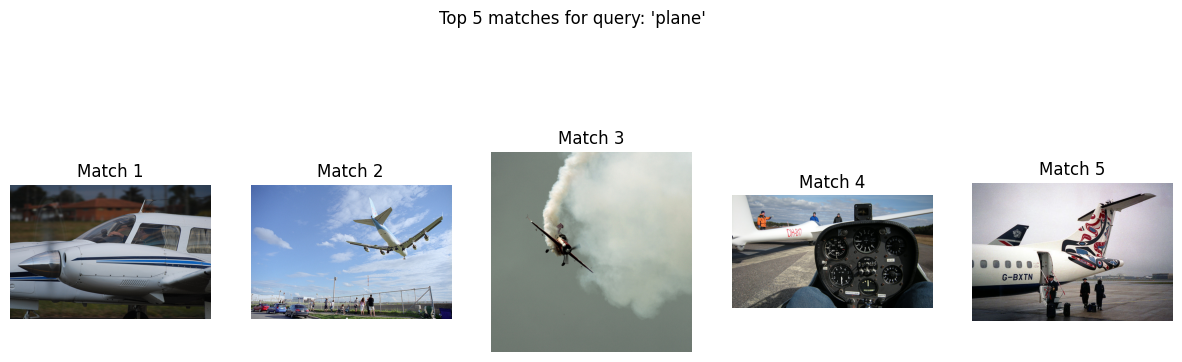

In [23]:
find_matches("plane")

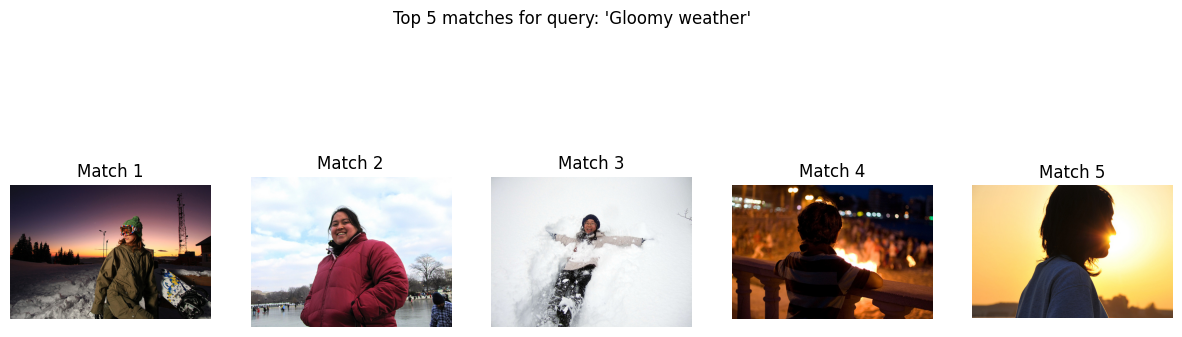

In [25]:
find_matches("Gloomy weather")

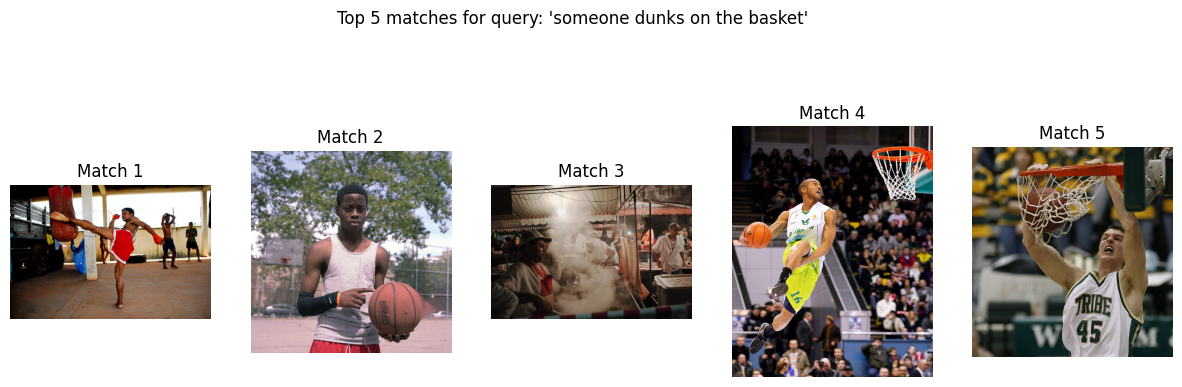

In [26]:
find_matches("someone dunks on the basket")